# Implementing k-Nearest Neighbors from scratch - The naive way

Recently I started looking for a job in the field of data science and in order to practice with possible machine learning related questions I decided to implement the most common algorithms from scratch using only numpy. In the following weeks I would like to share these implementation in my blog; today I am gonna start from $k$-NN. This is one of the easiest algorithms in the machine learning literature, but actually it's quite powerful!
The approach is very simple: 
- The fit method just stores the training data.
- At test time given a new sample compute the distances from all the samples in the training set.
- Sort these distances and consider the closest $k$ training elements to the test point (neighbors).
- The label in the test point will simply be the most represented label among the $k$ neighbors.

This high level explanation of the algorithm already provides a pseudo code for $k$-NN. Let's implement it in python!

*Note: in another blog post I describe $k$-NN and other ML algorithms in more detail. Check it out if you are interested: https://gialbo.github.io/Analysis-on-the-German-Credit-Risk-Dataset/#k-nearest-neighbors*

## Computing the distances

This is actually the first step in implementing $k$-NN. Various distance measures can be used, but the most common one is the Euclidean distance, so for this *homemade* version of the algorithm I am going to use that.

In [7]:
import numpy as np
# returns the Euclidean distance of two vectors
def compute_distance(x, other_x):
    return np.linalg.norm(x - other_x)

compute_distances(np.array([1, 2, 3]), np.array([4, 5, 6]))

5.196152422706632

## Predicting the labels

Once we have all the distances we will simply sort them and compute the label:

In [11]:
    # Takes as input a sorted list of tuples, each one in the form (distance, label) and the number of neighbors.
    # returns the most represented label in the neighborhood
    def compute_label(labeled_distances, n_neighbors):
        labels = [s[1] for s in labeled_distances[:n_neighbors]]
        labels_count = {}
        for label in labels:
            labels_count[label] = labels_count.get(label, 0) + 1
            
        best_label = None
        max_count = 0
        for k, v in labels_count.items():
            if v > max_count:
                max_count = v
                best_label = k
                
        return best_label
    
    
    labeled_distances = [(1.7542, 0), (3.523, 1), (2.124, 1), (1.123, 0)]
    sorted_labeled_distances = sorted(labeled_distances, key = lambda t: t[0])
    label = compute_label(sorted_labeled_distances, n_neighbors=3)
    print(f"The most represented label in the neighborhood is {label}")

The most represented label in the neighborhood is 0


The code is quite simple, I used a list of tuples. Each element represents a training point in terms of: distance from the point we are evaluating and label of the training point. Given this list I sort it using as key the distance (first element in the tuple), then I simply take the first $n_neighbors$ elements and look for the majority class inside the neighborhood. For doing this I keep in a dictionary the counts of the occurrences of each labels and then I select the label with the maximum count.

## Putting everything together

Basically the algorithm is implemented, the next step is putting everything inside a class and repeat the implemented operations for each point in the training and test set:

In [62]:
class HomemadeKNNs():
    def __init__(self, n_neighbors = 3):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.train_data = [(x_s, y_s) for x_s, y_s in zip(X, y)]
        
    
    def predict(self, X):
        
        y_hat = np.zeros((len(X)))
        for i, x in enumerate(X):
            labeled_distances = []
            for train_sample in self.train_data:
                distance = HomemadeKNNs.compute_distances(x, train_sample[0])
                labeled_distances.append((distance, train_sample[1]))
            labeled_distances = sorted(labeled_distances, key = lambda t: t[0])
            y_hat[i] = HomemadeKNNs.compute_label(labeled_distances, self.n_neighbors)
        
        return y_hat
                    
    @staticmethod
    def compute_distances(x, other_x):
        return np.linalg.norm(x - other_x)
    
    @staticmethod
    def compute_label(labeled_distances, n_neighbors):
        labels = [s[1] for s in labeled_distances[:n_neighbors]]
        labels_count = {}
        for label in labels:
            labels_count[label] = labels_count.get(label, 0) + 1
            
        best_label = None
        max_count = 0
        for k, v in labels_count.items():
            if v > max_count:
                max_count = v
                best_label = k
                
        return best_label


## Testing the algorithm

To test the algorithm I created a very simple 2D toy dataset consisting with only two labels.

In [63]:
import matplotlib.pyplot as plt

class SyntheticDataset2D():
    mean_0 = np.array((-1., 1.))
    std_0 = np.array((2., .2))    
    mean_1 = np.array((-2., 0))
    std_1 = np.array((1., .2))
    
    def __init__(self, n_classes=2, n_samples=200):
        self.n_classes = n_classes
        self.n_samples = n_samples
        
    def generate(self):
        
        samples_1 = []
        samples_2 = []
        for _ in range(self.n_samples // 2):
            samples_1.append(np.random.normal(self.mean_0, self.std_0))
            j = np.random.randint(0, 2)
            samples_2.append(np.random.normal(self.mean_1, self.std_1))
            
        X1 = np.stack(samples_1).clip(-4.99, 4.99)
        X2 = np.stack(samples_2).clip(-4.99, 4.99)
        X = np.concatenate((X1, X2), axis=0)
        y = np.zeros(self.n_samples)
        y[self.n_samples // 2:] = 1
        return X, y
    
    @staticmethod
    def plot_dataset(X, y):
        mask = y == 0
        X1 = X[mask]
        X2 = X[~mask]

        fig, ax = plt.subplots(figsize=(5,5), dpi=110)
        _ = ax.plot(X1[:,0], X1[:,1], '+m', alpha=1, label="Class 0")
        _ = ax.plot(X2[:,0], X2[:,1], '+c', alpha=1, label="Class 1")
        ax.grid()
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.legend()
        plt.show()

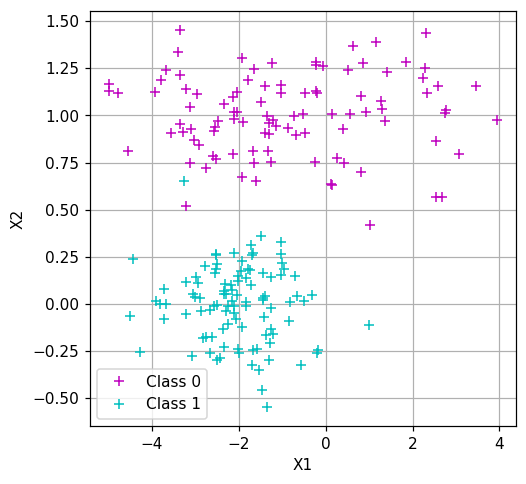

In [64]:
dataset = SyntheticDataset2D(2, 200)
X_train, y_train = dataset.generate()
SyntheticDataset2D.plot_dataset(X_train, y_train)

Let's see if everything works fine

In [65]:
model = HomemadeKNNs()
model.fit(X_train, y_train)

# Each time we call dataset.generate() data would be slightly different, but belonging to the same distribution
X_test, y_test = dataset.generate()
y_hat = model.predict(X_test)

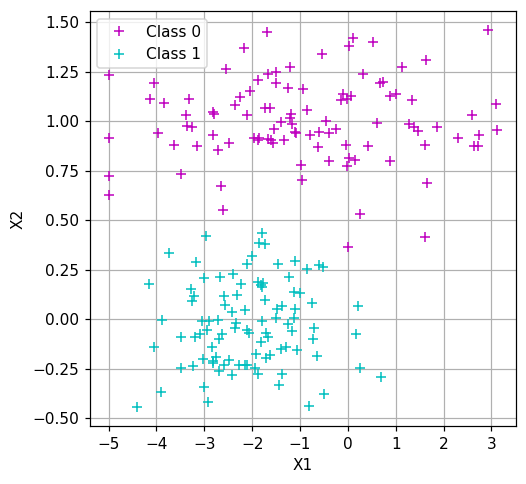

In [66]:
SyntheticDataset2D.plot_dataset(X_test, y_hat)

In [67]:
accuracy = np.sum(y_hat == y_test) / len(y_test)
print(f"The accuracy of the obtained model is {accuracy}")

The accuracy of the obtained model is 0.99


Our model seems to work pretty well. Another cool thing to is to plot the decision boundary and the training set on top to see what training samples are not classified correctly:

In [117]:
def plot_decision_boundary(model, X, y, min_vals=(-5, -2), max_vals=(5, 2)):
    min_vals = (-5, -2)
    max_vals = (5, 2)
    x1grid = np.arange(min_vals[0], max_vals[0], 0.1)
    x2grid = np.arange(min_vals[1], max_vals[1], 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    zz = model.predict(grid).reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=110)
    ax.contourf(xx, yy, zz, cmap='RdBu', levels=2, alpha=0.9)
    
    mask = y == 0
    X1 = X[mask]
    X2 = X[~mask]
        
    _ = ax.plot(X1[:,0], X1[:,1], '+m', label="class 0")
    _ = ax.plot(X2[:,0], X2[:,1], '+c', label="class 1")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    ax.legend()
    plt.show()

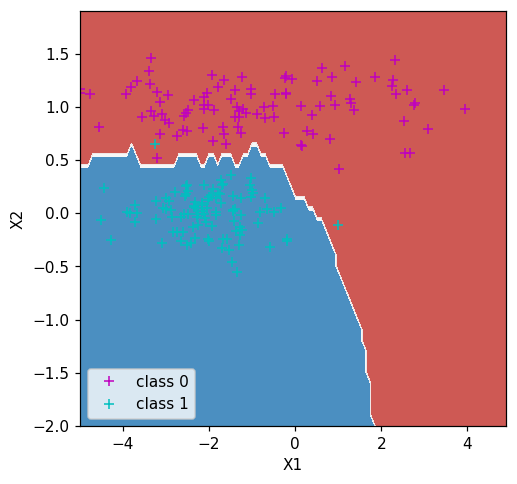

In [118]:
plot_decision_boundary(model, X_train, y_train)

## Conclusion

That's all for this very simple implementation of $k$-NN. Of course there exists various alternatives to implement the algorithm in a faster way. I was thinking to realize a part $2$ of this article in which I implement a more complex version of $k$-NN using the $k$-$d$ tree. Let me know if you liked this post and if I should do more articles on the topic by sending me an email: gilbertomanunza@gmail.com